<a href="https://colab.research.google.com/github/Kennedy87670/DatafestAfrica2023_Fruad_Detection_system/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost optuna
!pip install gwpy &> /dev/null

!command > /dev/null 2>&1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


## Fraud Detection for Online Payment Platform
The Fraud Detection dataset is a crucial asset for our business, providing valuable insights and opportunities for enhancing the security and trustworthiness of our online payment platform. This dataset represents transactions and user-related data collected over time from our platform.
1. Problem Definition
2. Data
3. Evaluation
4. Featuring
5. Modelling
6. Experimentation

## Problem Defintion
The primary goal is to develop an advanced predictive model to identify potentially fraudulent transactions.

## Data
The data was shared https://portfolio.diceytech.co.uk/project-opportunity/1694535858265x547950582392422400

## Evaluation

## Features
https://portfolio.diceytech.co.uk/project-opportunity/1694535858265x547950582392422400


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

In [3]:
#Plot the Features Importances
def plotImp(model, X , num = 30, fig_size = (60, 30)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('cb_importances-01.png')
    plt.show()
    return feature_imp.sort_values(by="Value",ascending=False)

In [4]:
#Plot the Features Importances
def plotImp(model, X , num = 30, fig_size = (60, 30)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('cb_importances-01.png')
    plt.show()
    return feature_imp.sort_values(by="Value",ascending=False)




#Reduce Memory Usage
def reduce_memory_usage(df):

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')

    return df

In [5]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="150" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive!
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [8]:
# load the data
path = '/content/drive/MyDrive/datafest' #/content/drive/MyDrive/DatafestAfrica2023 Data Science Datathon/Fraud Detection Dataset.csv

In [9]:
data = pd.read_csv(f'{path}/Fraud Detection Dataset.csv')

In [9]:
# # randomly select 100,000 rows from the datase
# sample_data = data.sample(1000, random_state=42)

## Data exploration (exploratory data analysis or EDA)



In [10]:
data.shape

(6000000, 32)

In [11]:
data.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag
0,51595306,9822,163.080,2023-01-02 07:47:54,4044,ACH Transfer,KOR,Charity,GPS Device,42.23.223.120,Links,Tizen,Industrial & Scientific,68,Doctor,66826.210,Prefer Not to Say,Pro,In Transit,9.340,24.220,Daytime,26,2.710,United Kingdom,NOK,Consultation Fee,343,cox.co.uk,3,Bluetooth Authentication,0
1,85052974,4698,430.740,2021-09-12 15:15:41,4576,2Checkout,VNM,Cashback,Medical Device,39.52.212.120,Beaker,Windows Server,Beauty & Cosmetics,22,Chemist,89356.710,Genderqueer,Pending Approval,Resolved,65.280,55.110,Daytime,60,3.950,Mexico,EGP,Cashback Reward,688,gmail.com,13,NFC Tag,1
2,23954324,8666,415.740,2023-01-12 17:25:58,4629,Google Wallet,MEX,Reward,Vehicle Infotainment System,243.180.236.29,Opera,Android,Real Estate,71,Nurse,58438.630,Male,Pro,Posted,44.050,53.840,Daytime,81,3.810,Qatar,MXN,Acquisition,371,rocketmail.com,7,Token,1
3,44108303,9012,565.890,2021-02-27 11:31:00,3322,Check,SGP,Purchase,Kiosk,212.186.227.14,Konqueror,CentOS,Appliances,78,Nurse,3426.920,Agender,Premium,Closed,21.700,21.620,Daytime,18,2.670,Spain,CLP,Loan Repayment,687,roadrunner.co.uk,15,Time-Based OTP,1
4,66622683,5185,955.490,2022-09-24 04:06:38,7609,Worldpay,HKG,Acquisition,Smart Mirror,166.113.10.199,Basilisk,Ubuntu,Jewelry,31,Physicist,53080.120,Male,Free,Refunded,56.630,53.710,Daytime,98,3.190,Israel,RUB,Dividend Reinvestment,605,protonmail.co.uk,17,Password,1


In [12]:
data.tail()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag
5999995,61037029,7480,448.990,2021-10-20 15:56:32,3346,Discover,SGP,Scholarship,Server,255.134.160.201,Chrome,Windows Mobile,Fitness & Nutrition,77,Plumber,81533.280,Genderqueer,Standard,Held for Security,8.150,59.180,Daytime,34,2.780,Russia,CHF,Invoice Payment,679,aim.com,14,Retina Scan,0
5999996,56515851,5636,841.390,2021-06-14 02:10:00,8415,Alipay,ZAF,Loan,Digital Camera,48.190.84.14,Safari,iOS,Appliances,42,Researcher,85016.110,Other,Active,Hold,15.010,19.920,Nighttime,80,2.600,Malaysia,HUF,Membership,706,cox.net,10,Social Media Login,1
5999997,66863972,5554,197.280,2021-11-06 22:33:19,4231,Afterpay,CAN,Service Charge,Barcode Scanner,7.21.196.39,Internet Explorer,Sailfish OS,Sporting Goods,45,Nurse,33282.350,Agender,Pending Approval,Void,91.180,25.830,Evening,12,1.350,Egypt,HKD,Admission,310,live.co.uk,14,Mobile App Notification,0
5999998,13449701,1275,358.330,2022-03-13 15:02:35,9614,JCB,UK,Fine,Robot,211.202.242.100,Waterfox,Chrome OS,Baby & Maternity,24,Biologist,6896.130,Non-Binary,Unverified,Processed,90.300,38.150,Nighttime,57,1.290,China,AED,Expense Reimbursement,460,rediffmail.com,16,Authentication App,0
5999999,89299426,5418,655.090,2022-10-20 12:04:27,7515,Payoneer,QAT,Refund,Smart Appliance,44.101.127.186,Lynx,QNX,Beauty & Cosmetics,57,Chef,40323.010,Male,Trial,In Transit,53.920,55.570,Evening,57,2.350,New Zealand,NOK,Rental Payment,340,live.co.uk,4,Password,1


In [13]:
data.describe()

,Transaction ID,User ID,Transaction Amount,Merchant ID,User Age,User Income,Location Distance,Time Taken for Transaction,User's Transaction History,Merchant's Reputation Score,User's Credit Score,Merchant's Business Age,Fraudulent Flag
count,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000,6000000.000
mean,55019059.604,5499.571,500.552,5500.817,49.002,50493.280,50.506,30.495,50.484,2.999,574.953,10.497,0.500
std,25980671.714,2598.744,288.417,2598.350,18.185,28582.234,28.576,17.036,28.867,1.154,159.020,5.765,0.500
min,10000041.000,1000.000,1.000,1000.000,18.000,1000.020,1.000,1.000,1.000,1.000,300.000,1.000,0.000
25%,32516659.750,3248.000,250.790,3251.000,33.000,25734.458,25.760,15.740,25.000,2.000,437.000,5.000,0.000
50%,55029874.000,5499.000,500.510,5501.000,49.000,50502.940,50.510,30.500,50.000,3.000,575.000,10.000,0.000
75%,77524866.250,7751.000,750.440,7752.000,65.000,75234.535,75.250,45.260,75.000,4.000,713.000,15.000,1.000
max,99999883.000,9999.000,1000.000,9999.000,80.000,100000.000,100.000,60.000,100.000,5.000,850.000,20.000,1.000


In [14]:
#data.rename(columns = {'Fraudulent Flag':'Fraudulent'}, inplace = True)

In [15]:
# # Check for missing values
print("Missing Values:\n", data.isnull().sum())


Missing Values:
 Transaction ID                       0
User ID                              0
Transaction Amount                   0
Transaction Date and Time            0
Merchant ID                          0
Payment Method                       0
Country Code                         0
Transaction Type                     0
Device Type                          0
IP Address                           0
Browser Type                         0
Operating System                     0
Merchant Category                    0
User Age                             0
User Occupation                      0
User Income                          0
User Gender                          0
User Account Status                  0
Transaction Status                   0
Location Distance                    0
Time Taken for Transaction           0
Transaction Time of Day              0
User's Transaction History           0
Merchant's Reputation Score          0
User's Device Location               0
Transact

## Data Exploration

In [10]:
# Create new date-related features
data['Transaction Month'] = pd.to_datetime(data['Transaction Date and Time']).dt.month
data['Transaction Weekday'] = pd.to_datetime(data['Transaction Date and Time']).dt.weekday
data['Transaction Day'] = pd.to_datetime(data['Transaction Date and Time']).dt.day
data['Transaction Dayname'] = pd.to_datetime(data['Transaction Date and Time']).dt.day_name()
data['Transaction Hour'] = pd.to_datetime(data['Transaction Date and Time']).dt.hour
data['Transaction Year'] = pd.to_datetime(data['Transaction Date and Time']).dt.year
data['Age Group'] = pd.cut(data['User Age'], bins=[0, 18, 35, 60, 100], labels=['Child', 'Young Adult', 'Adult', 'Elders'])

data['Transaction Amount Category'] = pd.cut(data['Transaction Amount'], bins=[0, 100, 500, 1000, float('inf')], labels=['Small', 'Medium', 'Large', 'Extra Large'])



# Drop the original 'Transaction Date and Time' column
data.drop(columns=['Transaction Date and Time'], inplace=True)

data.drop(columns = ['User Age'], inplace=True )

data.drop(columns = ['Transaction Amount'], inplace=True )

## Data Exploration

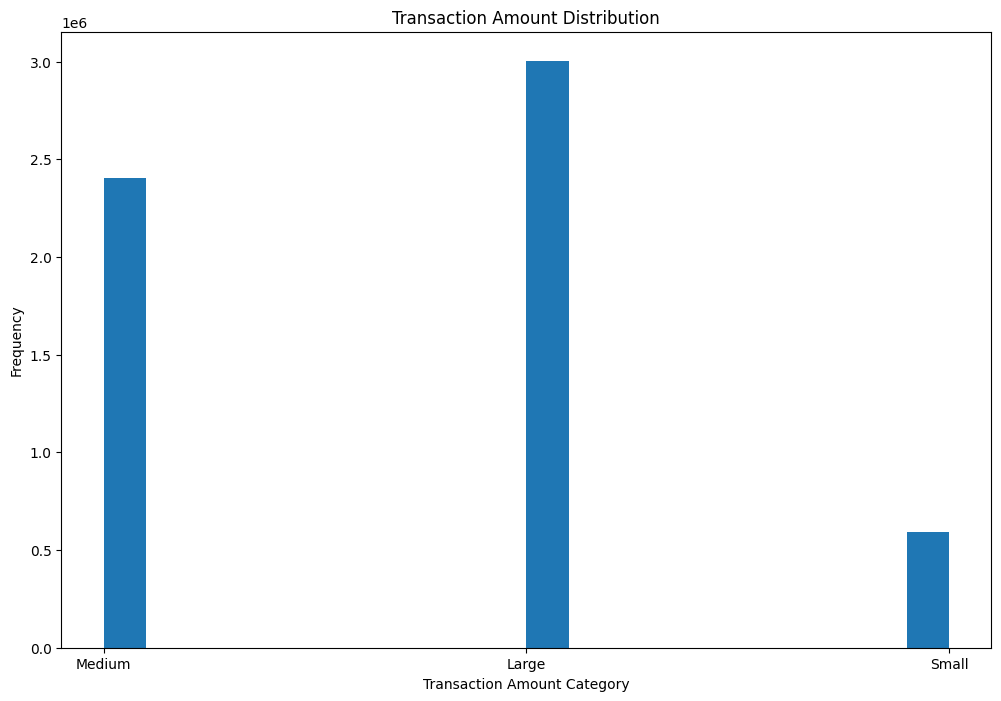

In [17]:
# Transcation Amount
plt.hist(data['Transaction Amount Category'], bins=20)
plt.xlabel('Transaction Amount Category')
plt.ylabel('Frequency')
plt.title('Transaction Amount Distribution')
plt.show()

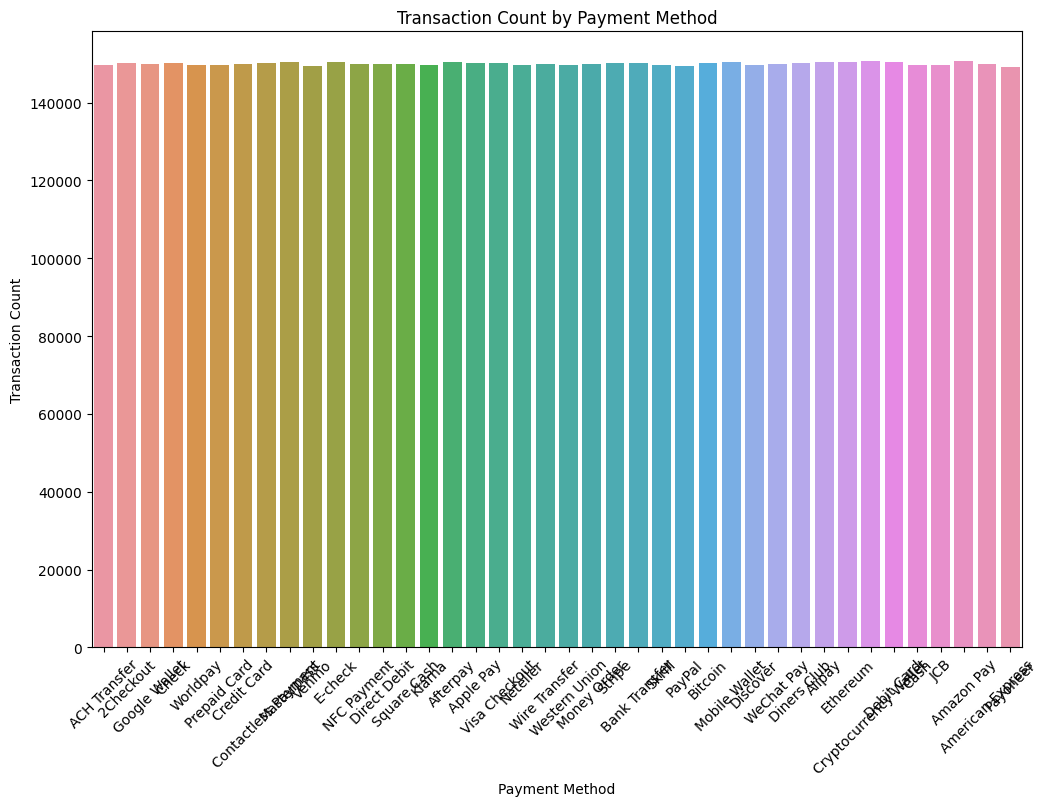

In [18]:
# Transaction Count by Payment Method:
# Bar chart showing the count of transactions for each payment method.

import seaborn as sns
sns.countplot(data=data, x='Payment Method')
plt.xticks(rotation=45)
plt.xlabel('Payment Method')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Payment Method')
plt.show()


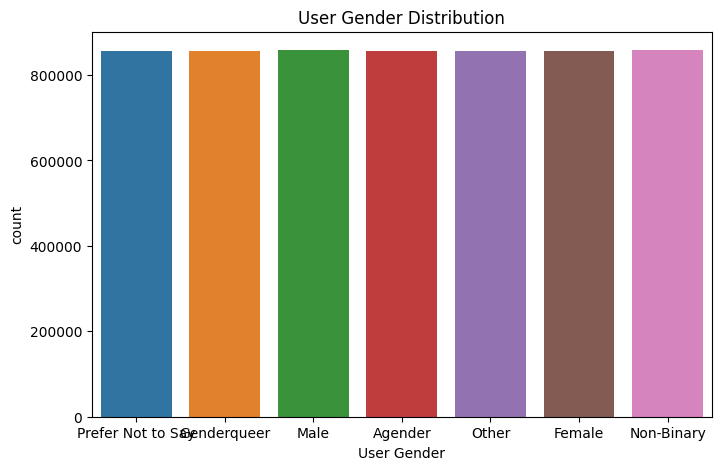

In [19]:
# Gender Distrribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='User Gender' )
plt.title('User Gender Distribution')
plt.show()


In [12]:
# # Transaction Amount by Country:
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=data, x='Country Code')
# plt.xlabel('Country Code')
# plt.ylabel('Transaction Amount')
# plt.title('Transaction Amount by Country')
# plt.show()


In [14]:
# # Transaction Amount by Transaction Type
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=data, x='Transaction Type', y='Transaction Amount Category')
# plt.title('Transaction Amount by Transaction Type')
# plt.xticks(rotation=90)
# plt.show()


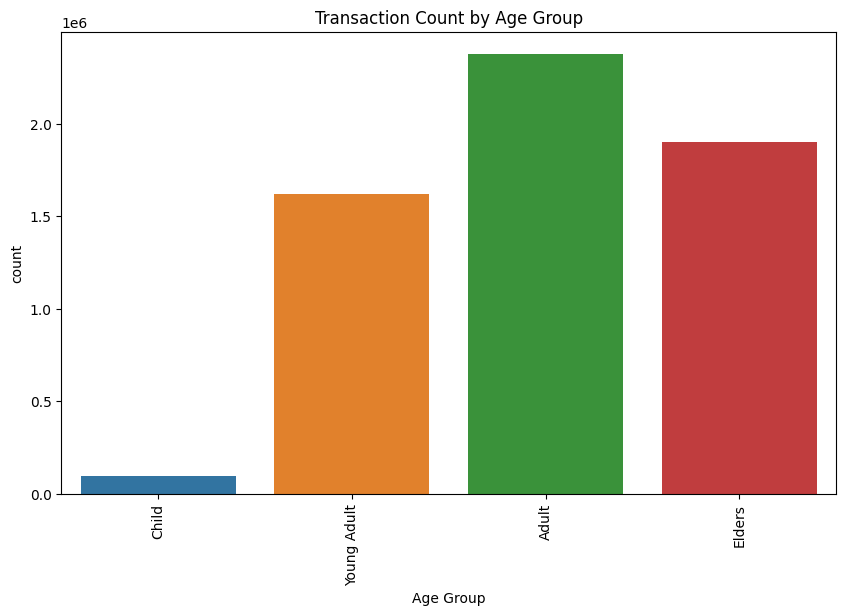

In [15]:
# Transaction Count by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Age Group')
plt.title('Transaction Count by Age Group')
plt.xticks(rotation=90)
plt.show()


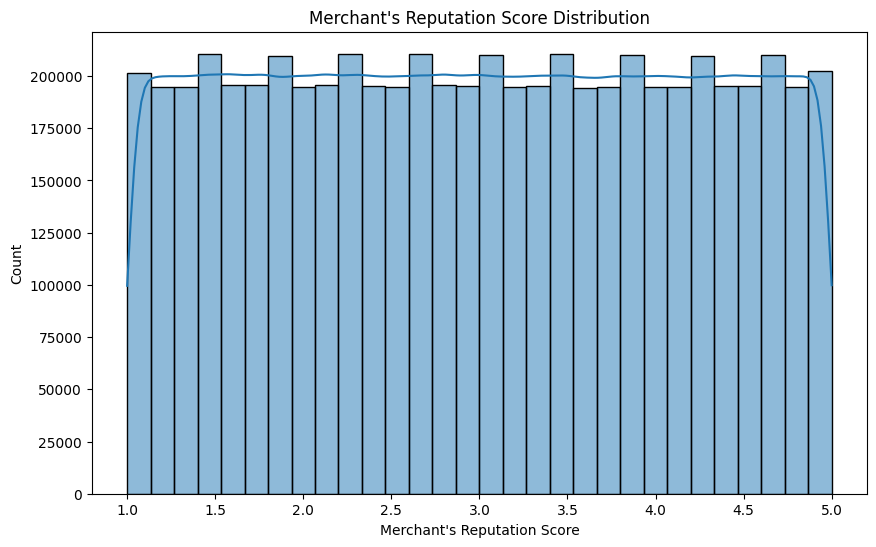

In [16]:
# Merchant's Reputation Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="Merchant's Reputation Score", bins=30, kde=True)
plt.title("Merchant's Reputation Score Distribution")
plt.xlabel("Merchant's Reputation Score")
plt.show()


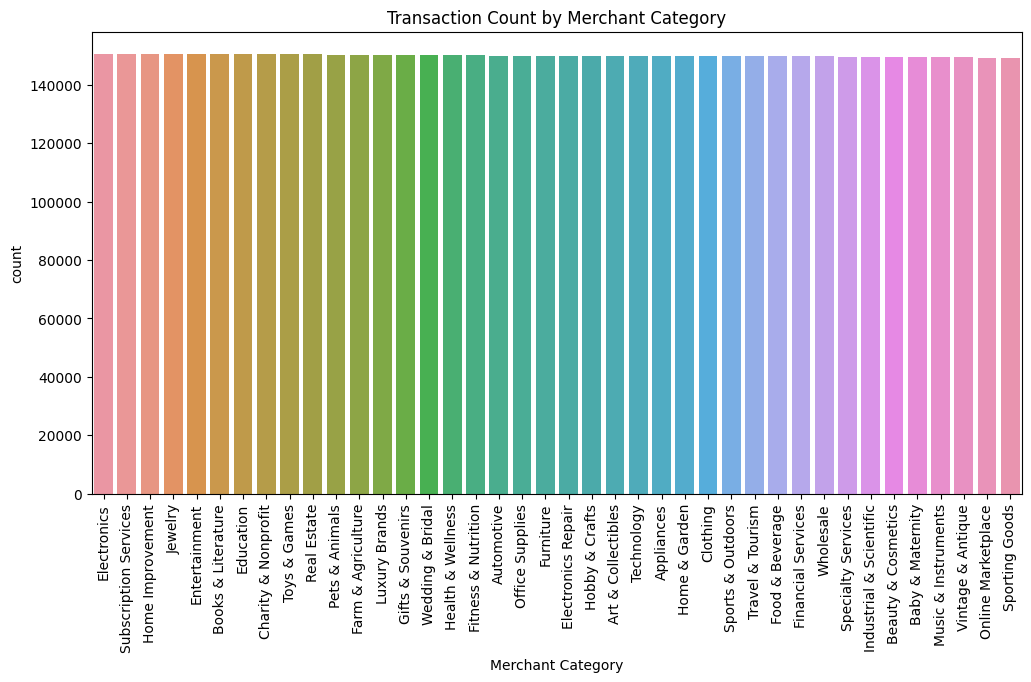

In [17]:
# Transaction Count by Merchant Category
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Merchant Category', order=data['Merchant Category'].value_counts().index)
plt.title('Transaction Count by Merchant Category')
plt.xticks(rotation=90)
plt.show()


In [19]:
# # Transaction Amount vs. User's Credit Score
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=data, x="User's Credit Score", y='Transaction Amount Category')
# plt.title("Transaction Amount vs. User's Credit Score")
# plt.show()

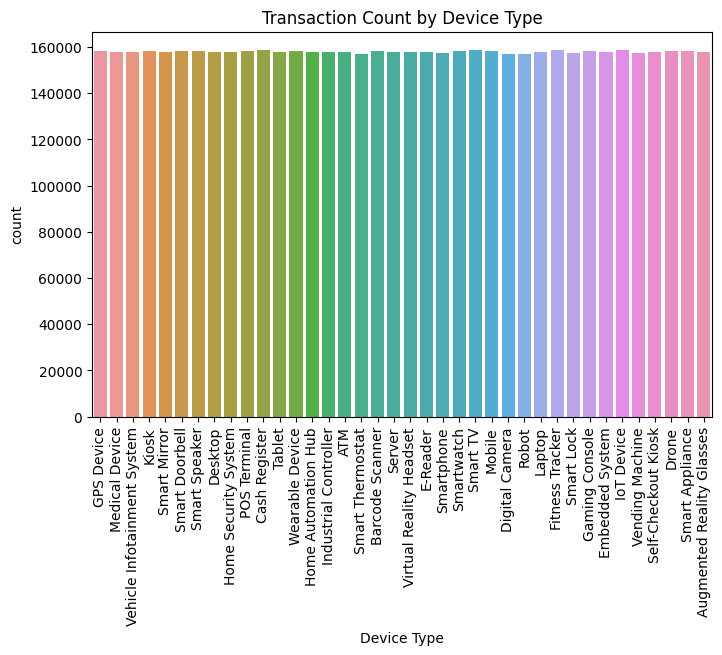

In [20]:
# Transaction Count by Device Type
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Device Type')
plt.title('Transaction Count by Device Type')
plt.xticks(rotation=90)
plt.show()


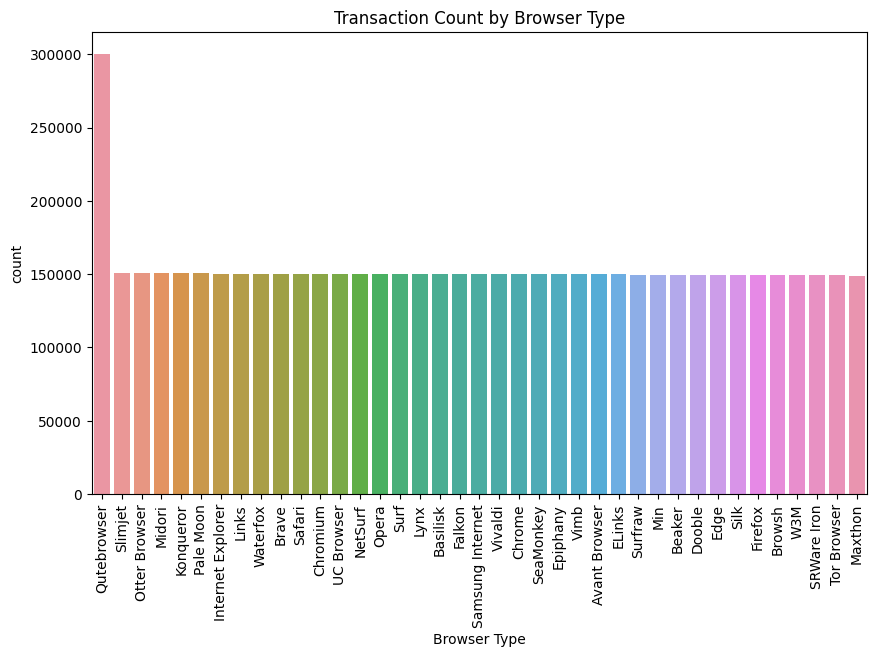

In [21]:
# Transaction Count by Browser Type
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Browser Type', order=data['Browser Type'].value_counts().index)
plt.title('Transaction Count by Browser Type')
plt.xticks(rotation=90)
plt.show()


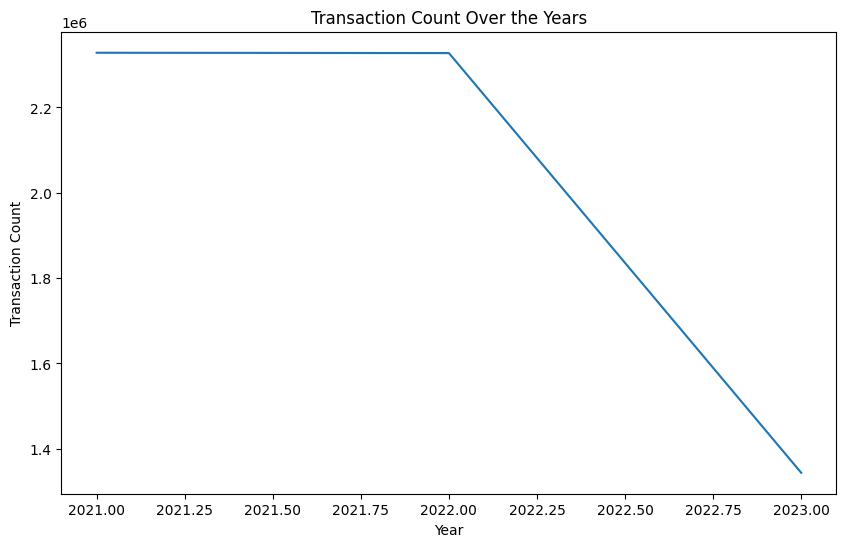

In [22]:
# Line Plot Over Time (e.g., Transaction Count Over the Years):
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Transaction Year', y='Transaction ID', estimator=len)
plt.title('Transaction Count Over the Years')
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.show()

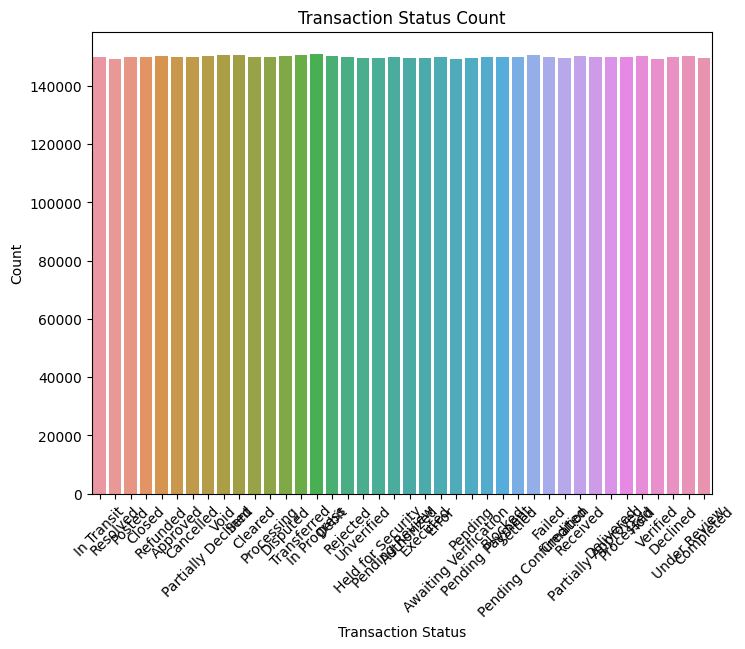

In [24]:
#Transaction Status
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='Transaction Status', y='Transaction ID', estimator=len)
plt.title('Transaction Status Count')
plt.xlabel('Transaction Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


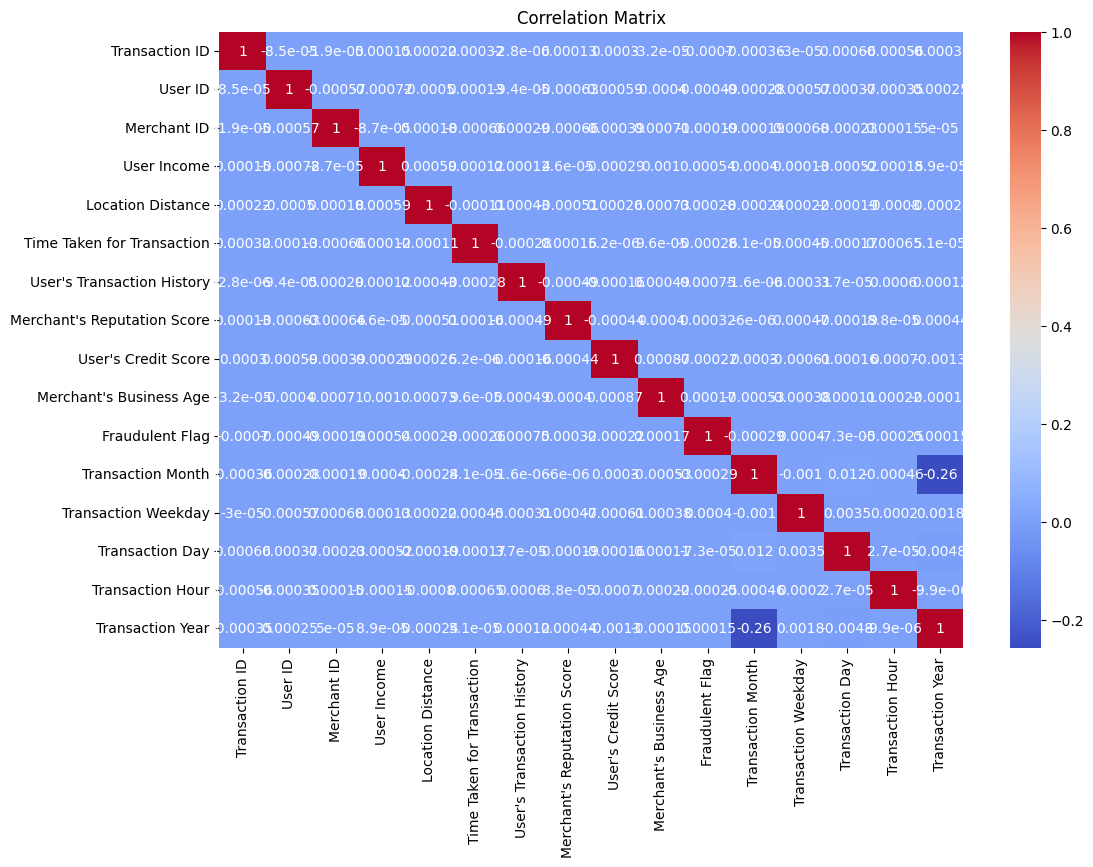

In [25]:
# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


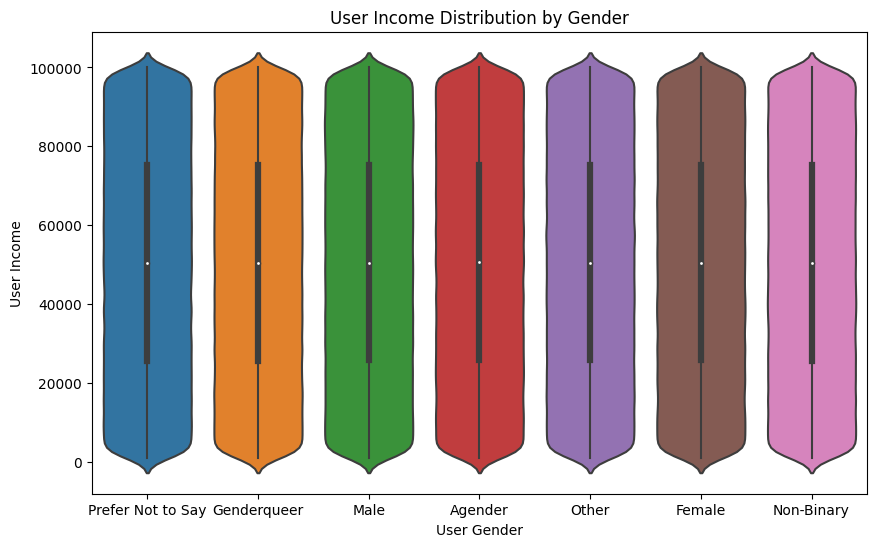

In [26]:
# User Income Distribution by Gender):
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='User Gender', y='User Income')
plt.title('User Income Distribution by Gender')
plt.xlabel('User Gender')
plt.ylabel('User Income')
plt.show()


In [27]:
def classify_categorical_and_numerical_values(df):
  """Classifies categorical and numerical values based on the data type of the feature.

  Args:
    df: A Pandas DataFrame.

  Returns:
    A dictionary containing the categorical and numerical feature names.
  """

  categorical_feature_names = []
  numerical_feature_names = []

  for feature_name in df.columns:
    if df[feature_name].dtype == 'int64' or df[feature_name].dtype == 'float64':
      # The feature is numerical.
      numerical_feature_names.append(feature_name)
    else:
      # The feature is categorical.
      categorical_feature_names.append(feature_name)

  return {
      'categorical_feature_names': categorical_feature_names,
      'numerical_feature_names': numerical_feature_names,
  }

In [28]:

categorical_and_numerical_feature_names = classify_categorical_and_numerical_values(data)

print('Categorical feature names:')
print(categorical_and_numerical_feature_names['categorical_feature_names'])

print('Numerical feature names:')
print(categorical_and_numerical_feature_names['numerical_feature_names'])

Categorical feature names:
['Payment Method', 'Country Code', 'Transaction Type', 'Device Type', 'IP Address', 'Browser Type', 'Operating System', 'Merchant Category', 'User Occupation', 'User Gender', 'User Account Status', 'Transaction Status', 'Transaction Time of Day', "User's Device Location", 'Transaction Currency', 'Transaction Purpose', "User's Email Domain", 'Transaction Authentication Method', 'Transaction Dayname', 'Age Group', 'Transaction Amount Category']
Numerical feature names:
['Transaction ID', 'User ID', 'Merchant ID', 'User Income', 'Location Distance', 'Time Taken for Transaction', "User's Transaction History", "Merchant's Reputation Score", "User's Credit Score", "Merchant's Business Age", 'Fraudulent Flag', 'Transaction Month', 'Transaction Weekday', 'Transaction Day', 'Transaction Hour', 'Transaction Year']


In [ ]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Create a categorical transformer
categorical_transformer = Pipeline([
    ('get_dummies', pd.get_dummies(data=data, sparse=True))
])


# Combine transformers into a single preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, categorical_and_numerical_feature_names['numerical_feature_names']),
        ('cat', categorical_transformer, categorical_and_numerical_feature_names['categorical_feature_names'])
    ])

# Fit and transform the data
X_transformed = preprocessor.fit_transform(data)

# Convert the transformed data back to a DataFrame for inspection
columns = numerical_and_numerical_feature_names['numerical_feature_names'] + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_and_numerical_feature_names['categorical_feature_names']))
X_transformed_df = pd.DataFrame(X_transformed, columns=columns)

# Print the transformed DataFrame
print(X_transformed_df)

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, data['Fraudulent Flag'], test_size=0.25, random_state=42)

# Create and train a decision tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Create and train a support vector machine model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Create and train a random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate the models on the test set
dt_test_score = dt_model.score(X_test, y_test)
svm_test_score = svm_model.score(X_test, y_test)
rf_test_score = rf_model.score(X_test, y_test)

# Print the test scores
print('Decision tree test score:', dt_test_score)
print('Support vector machine test score:', svm_test_score)
print('Random forest test score:', rf_test_score)

# Choose the model with the best test score
best_model = rf_model if rf_test_score > svm_test_score and rf_test_score > dt_test_score else svm_model if svm_test_score > dt_test_score else dt_model

# Print the best model
print('Best model:', best_model)